# MCMC Parameter Estimation for LambdaCDM (with $\Omega_\mathrm{radiation}$) using DESI Data

Now we include $\Omega_\mathrm{radiation}$ as a free parameter and use the `LambdaCDM` class for the model.

In [10]:
import sys
sys.path.append('/home/giorgio/Documents/Scuola/Università/Università_di_Genova/IV_ANNO/II_Semestre/Astrofisica Computazionale/ESAME/ToloAstroCosmoLib')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyACC.cosmology.cosmology import LambdaCDM
from pyACC.cosmology.distances import CosmologicalDistances

# Load DESI data
file_data = "data.csv"
data = pd.read_csv(file_data)
data = data.astype(float)

z = data["z_eff"].values
D_V_obs = data["D_V / r_d"].values
D_V_err = data["D_V / r_d_err"].values

In [11]:
# Define the log-likelihood function for LambdaCDM with Omega_radiation
def log_likelihood(params):
    H0, Omega_m, Omega_Lambda, Omega_radiation, r_d = params
    # Reasonable bounds for all parameters
    if not (60 < H0 < 80 and 0.1 < Omega_m < 0.5 and 0.5 < Omega_Lambda < 0.9 and 0.0 <= Omega_radiation < 0.01 and 130 < r_d < 180):
        return -np.inf
    model = LambdaCDM(H0, Omega_m, Omega_Lambda, Omega_radiation)
    distances = CosmologicalDistances(model.H)
    D_V_model = np.array([distances.volume_distance(z_i) for z_i in z])
    # Gaussian log-likelihood
    return -0.5 * np.sum(((D_V_obs * r_d - D_V_model) / (D_V_err * r_d)) ** 2)

In [12]:
# Set up the MCMC sampler using emcee
import emcee

ndim = 5        # H0, Omega_m, Omega_Lambda, Omega_radiation, r_d
nwalkers = 50   # More walkers for higher dimensions
nsteps = 2500  # Number of steps per chain

# Initial guess and spread for walkers
initial = np.array([68.0, 0.3, 0.7, 0.0001, 147.0])
positions = initial + 1e-2 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood)
sampler.run_mcmc(positions, nsteps, progress=True)

  0%|          | 0/2500 [00:00<?, ?it/s]/home/giorgio/anaconda3/envs/acc-env/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 2500/2500 [00:36<00:00, 68.65it/s]


State([[ 6.99422840e+01  2.47122923e-01  6.25005836e-01  2.90629867e-03
   1.43709851e+02]
 [ 7.48753362e+01  2.55471759e-01  6.28698799e-01  5.33102817e-03
   1.33684291e+02]
 [ 7.03856887e+01  2.92723765e-01  6.80339602e-01  3.71313915e-03
   1.43055885e+02]
 [ 6.00887722e+01  2.49489645e-01  6.07645653e-01  3.45914775e-03
   1.66119229e+02]
 [ 6.79783709e+01  3.19346481e-01  7.59886777e-01  4.27446961e-03
   1.50341946e+02]
 [ 7.16571497e+01  2.79852857e-01  7.13186898e-01  2.38618453e-03
   1.43308201e+02]
 [ 6.35678913e+01  2.40011859e-01  6.53528604e-01  9.60249441e-03
   1.59064449e+02]
 [ 7.02866577e+01  2.61305836e-01  6.03792405e-01  9.12416746e-04
   1.42006473e+02]
 [ 6.36741113e+01  1.98061291e-01  5.35927635e-01  9.05810844e-03
   1.55717689e+02]
 [ 6.61072326e+01  3.01478846e-01  6.92121499e-01  4.87159905e-03
   1.52060607e+02]
 [ 7.51690039e+01  2.59690508e-01  6.11280486e-01  9.17887416e-03
   1.31767257e+02]
 [ 7.08320031e+01  2.54117497e-01  5.27178880e-01  1.697644

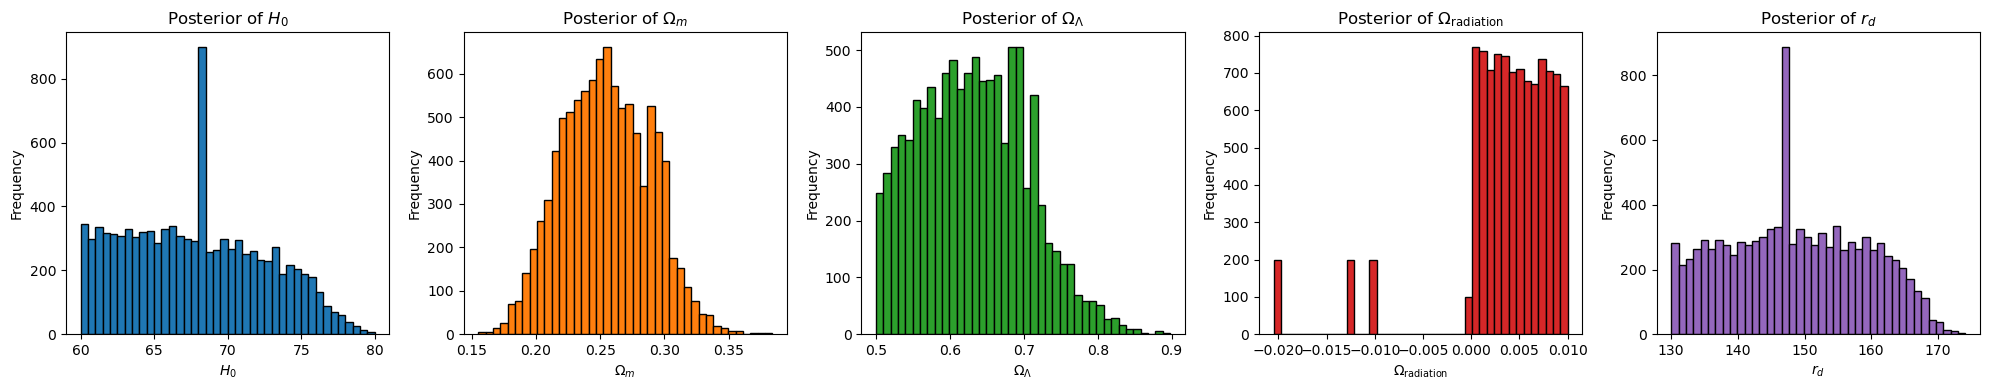

$H_0$: 67.9093 (+5.2500, -5.4218)
$\Omega_m$: 0.2536 (+0.0374, -0.0347)
$\Omega_\Lambda$: 0.6290 (+0.0775, -0.0782)
$\Omega_\mathrm{radiation}$: 0.0045 (+0.0037, -0.0035)
$r_d$: 147.4359 (+13.0058, -10.6031)


In [13]:
# Analyze and plot the results with matplotlib
samples = sampler.get_chain(discard=500, thin=10, flat=True)

labels = [r"$H_0$", r"$\Omega_m$", r"$\Omega_\Lambda$", r"$\Omega_\mathrm{radiation}$", r"$r_d$"]
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i in range(5):
    axes[i].hist(samples[:, i], bins=40, color='C'+str(i), edgecolor='k')
    axes[i].set_xlabel(labels[i])
    axes[i].set_ylabel("Frequency")
    axes[i].set_title(f"Posterior of {labels[i]}")

plt.tight_layout()
plt.show()

# Print mean and standard deviation for each parameter
for i, label in enumerate(labels):
    median, lower, upper = np.percentile(samples[:, i], [50, 16, 84])
    print(f"{label}: {median:.4f} (+{upper-median:.4f}, -{median-lower:.4f})")

## Corner Plot of Posterior Distributions

Let's visualize the joint and marginal posterior distributions for all parameters using the `corner` library.

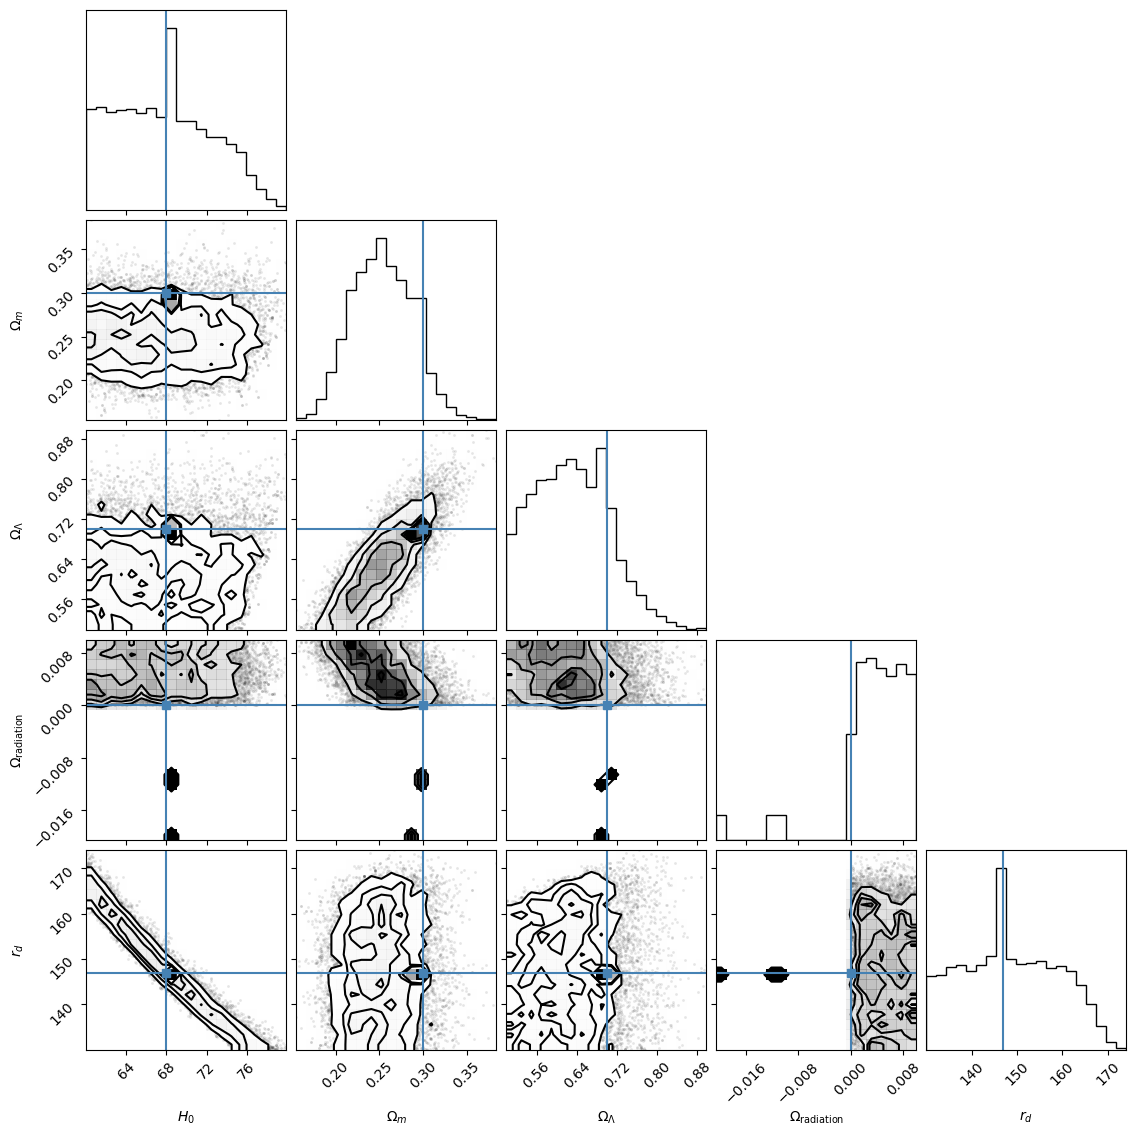

In [14]:
import corner

labels = [r"$H_0$", r"$\Omega_m$", r"$\Omega_\Lambda$", r"$\Omega_\mathrm{radiation}$", r"$r_d$"]
fig = corner.corner(samples, labels=labels, truths=initial)